<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/S5EVA6_Attempt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Final Accuracy: 99.46**
###  Number of parameters - 9032

In [1]:
!nvidia-smi

Fri Jun  4 17:07:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pytorch-ignite
!pip install torchsummary
!pip install wandb
!pip install gradio
!pip install netron
!pip install plotly --upgrade

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
import pandas as pd
import numpy as np

In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from torch.utils.data import DataLoader
from ignite.handlers import Checkpoint, DiskSaver


import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

from argparse import ArgumentParser
from tqdm import tqdm
import os

In [6]:
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

In [7]:
import wandb
#wandb.init()
#!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204
#wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
# WandB – Config is a variable that holds and saves hyperparameters and inputs
hyperparameter_defaults = dict(
    dropout = 0.1,
    channels_one = 16,
    channels_two = 32,
    batch_size = 64,
    test_batch_size=64,
    lr = 0.015,
    momentum = 0.9,
    no_cuda = False,
    seed = 1,
    epochs = 20,
    bias = False,
    log_interval = 10
    )

wandb.init(config=hyperparameter_defaults, project="news4eva4")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
config = wandb.config


wandb: Currently logged in as: rajy4683 (use `wandb login --relogin` to force relogin)


In [10]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [11]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


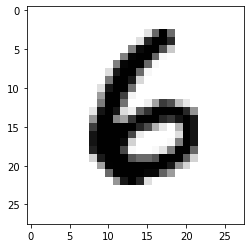

In [13]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout_val = config.dropout
        self.bias = False
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, stride=1,bias=self.bias),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(8, 8, 3, padding=1, stride=1,bias=self.bias),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            # nn.Conv2d(8, 8, 3, padding=1, bias=self.bias),
            # nn.ReLU(),
            # nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),            
            nn.Dropout(self.dropout_val)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1,stride=1, bias=self.bias),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(16, 16, 3, padding=1, bias=self.bias),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val),
            # nn.Conv2d(16, 16, 3, padding=1, bias=self.bias),
            # nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.MaxPool2d(2, 2),
            # nn.Dropout(self.dropout_val)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3,bias=self.bias),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(16, 16, 3,bias=self.bias),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val)
        )
        
        self.gap_linear = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(16, 10, 1, bias=self.bias)
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        #x = x.view(x.size(0), -1)
        x = self.gap_linear(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x


In [15]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
         MaxPool2d-8            [-1, 8, 14, 14]               0
           Dropout-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           1,152
             ReLU-11           [-1, 16, 14, 14]               0
      BatchNorm2d-12           [-1, 16, 14, 14]              32
          Dropout-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 16,

In [16]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
train_losses = []
test_losses = []
train_acc = []
test_acc = []

from tqdm import tqdm
def train(args, model, device, train_loader, optimizer, epoch_number):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_accuracy += pred.eq(target.view_as(pred)).sum().item()

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        epoch_number, train_loss, train_accuracy, len(train_loader.dataset),
        100. * train_accuracy / len(train_loader.dataset)))
    train_accuracy = (100. * train_accuracy) / len(train_loader.dataset)
    train_acc.append(train_accuracy)
    train_losses.append(train_loss)

    return train_accuracy, train_loss

def test(args, model, device, test_loader,classes,epoch_number):
    model.eval()
    test_loss = 0
    correct = 0
    example_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
        #example_images.append(wandb.Image(
        #        data[0], caption="Pred: {} Truth: {}".format(classes[pred[0].item()], classes[target[0]])))

    test_loss /= len(test_loader.dataset)
    test_accuracy = (100. * correct) / len(test_loader.dataset)

    print('\nEpoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        epoch_number, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(test_accuracy)
    test_losses.append(test_loss)

    return test_accuracy, test_loss

In [18]:
#model = Net(start_channels=16,exponetate_layers=False).to(device)
#wandb.init(project="news4eva4")

hyperparameter_defaults = dict(
    dropout = 0.1,
    channels_one = 16,
    channels_two = 32,
    batch_size = 64,
    test_batch_size=64,
    lr = 0.015,
    momentum = 0.9,
    no_cuda = False,
    seed = 1,
    epochs = 15,
    bias = False,
    log_interval = 10
    )
wandb.init(config=hyperparameter_defaults, project="news4eva4")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
config = wandb.config

def main():
    use_cuda = not config.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    
    # Set random seeds and deterministic pytorch for reproducibility
    # random.seed(config.seed)       # python random seed
    torch.manual_seed(config.seed) # pytorch random seed
    # numpy.random.seed(config.seed) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # Load the dataset: We're training our CNN on CIFAR10 (https://www.cs.toronto.edu/~kriz/cifar.html)
    # First we define the tranformations to apply to our images
    #kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=train_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)

    # Initialize our model, recursively go over all modules and convert their parameters and buffers to CUDA tensors (if device is set to cuda)
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=config.lr,
                          momentum=config.momentum)
    
    # WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
    # Using log="all" log histograms of parameter values in addition to gradients
    wandb.watch(model, log="all")

    for epoch in range(1, config.epochs + 1):
        epoch_train_acc,epoch_train_loss = train(config, model, device, train_loader, optimizer, epoch)
        epoch_test_acc,epoch_test_loss = test(config, model, device, test_loader, classes,epoch)
        wandb.log({ "Train Accuracy": epoch_train_acc, 
                   "Train Loss": epoch_train_loss, 
                   "Test Accuracy":epoch_test_acc, 
                   "Test Loss": epoch_test_loss})
        
    # WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.
    torch.save(model.state_dict(), "model.h5")
    wandb.save('model.h5')

if __name__ == '__main__':
    main()

Train Accuracy,99.02333
Train Loss,0.0005
Test Accuracy,99.42
Test Loss,0.01955
_runtime,343
_timestamp,1622826811
_step,19


Train Accuracy,▁▆▆▇▇▇▇▇████████████
Train Loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,▁▄▅▆▇▇▇█▇▇█████▇▇▇██
Test Loss,█▅▄▄▃▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
loss=0.12114337831735611 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 64.24it/s]


Epoch: 1 Train set: Average loss: 0.0033, Accuracy: 56327/60000 (93.878%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 Test set: Average loss: 0.0453, Accuracy: 9854/10000 (98.540%)



loss=0.04602988064289093 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 64.14it/s]


Epoch: 2 Train set: Average loss: 0.0013, Accuracy: 58473/60000 (97.455%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 Test set: Average loss: 0.0358, Accuracy: 9889/10000 (98.890%)



loss=0.05600472539663315 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 63.24it/s]


Epoch: 3 Train set: Average loss: 0.0011, Accuracy: 58750/60000 (97.917%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 Test set: Average loss: 0.0300, Accuracy: 9907/10000 (99.070%)



loss=0.1633758842945099 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 63.25it/s]


Epoch: 4 Train set: Average loss: 0.0010, Accuracy: 58876/60000 (98.127%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 Test set: Average loss: 0.0298, Accuracy: 9912/10000 (99.120%)



loss=0.009293059818446636 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 64.68it/s]


Epoch: 5 Train set: Average loss: 0.0008, Accuracy: 58990/60000 (98.317%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 Test set: Average loss: 0.0256, Accuracy: 9927/10000 (99.270%)



loss=0.016532447189092636 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 63.68it/s]


Epoch: 6 Train set: Average loss: 0.0008, Accuracy: 59118/60000 (98.530%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 Test set: Average loss: 0.0252, Accuracy: 9934/10000 (99.340%)



loss=0.07251843810081482 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 62.08it/s]


Epoch: 7 Train set: Average loss: 0.0008, Accuracy: 59091/60000 (98.485%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 Test set: Average loss: 0.0240, Accuracy: 9928/10000 (99.280%)



loss=0.004052315838634968 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 60.31it/s]


Epoch: 8 Train set: Average loss: 0.0007, Accuracy: 59146/60000 (98.577%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 Test set: Average loss: 0.0222, Accuracy: 9942/10000 (99.420%)



loss=0.08369793742895126 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.76it/s]


Epoch: 9 Train set: Average loss: 0.0007, Accuracy: 59204/60000 (98.673%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.270%)



loss=0.034950919449329376 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 57.66it/s]


Epoch: 10 Train set: Average loss: 0.0007, Accuracy: 59224/60000 (98.707%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 10 Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.290%)



loss=0.016334975138306618 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 62.07it/s]



Epoch: 11 Train set: Average loss: 0.0006, Accuracy: 59290/60000 (98.817%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 Test set: Average loss: 0.0209, Accuracy: 9942/10000 (99.420%)



loss=0.17274031043052673 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 62.39it/s]


Epoch: 12 Train set: Average loss: 0.0006, Accuracy: 59277/60000 (98.795%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 12 Test set: Average loss: 0.0217, Accuracy: 9936/10000 (99.360%)



loss=0.01612127758562565 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 62.34it/s]


Epoch: 13 Train set: Average loss: 0.0006, Accuracy: 59292/60000 (98.820%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 13 Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.420%)



loss=0.022306937724351883 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 61.04it/s]


Epoch: 14 Train set: Average loss: 0.0006, Accuracy: 59320/60000 (98.867%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 Test set: Average loss: 0.0230, Accuracy: 9940/10000 (99.400%)



loss=0.0014928244054317474 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 61.93it/s]


Epoch: 15 Train set: Average loss: 0.0006, Accuracy: 59340/60000 (98.900%)




Epoch: 15 Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.390%)



## RESULTS of the Final Run

In [19]:
def plot_metrics(metrics_dataframe_local):
    dataset_metrics = metrics_dataframe_local.loc[:,['Test Accuracy', 'Test Loss']].dropna().reset_index().drop(columns='index')
    final_run_metrics = pd.concat([metrics_dataframe.loc[:,['Train Accuracy', 'Train Loss']].dropna().reset_index().drop(columns='index'), 
                                   metrics_dataframe.loc[:,['Test Accuracy', 'Test Loss']].dropna().reset_index().drop(columns='index')],axis=1)
    return final_run_metrics
    # final_run_metrics.loc[:,['Train Accuracy', 'Test Accuracy']].plot()
    # final_run_metrics.loc[:,['Train Loss', 'Test Loss']].plot()


In [21]:
import wandb
#api = wandb.Api()

# run is specified by <entity>/<project>/<run id>
runs = api.runs('rajy4683/news4eva4')
run = runs.objects[0] #.history()

# save the metrics for the run to a csv file
metrics_dataframe = run.history()
metrics_dataframe.to_csv("metrics.csv")

In [23]:
for itr in runs:
    if itr.name == 'cosmic-sound-567':
        run = itr

In [24]:
metrics_dataframe = run.history()
metrics_dataframe.to_csv("metrics.csv")

In [25]:
max_accuracy_idx = metrics_dataframe['Test Accuracy'].idxmax()
metrics_dataframe.loc[max_accuracy_idx, ['_step', 'Test Accuracy', 'Train Accuracy', 'Train Loss', 'Test Loss']]

_step                       7
Test Accuracy           99.42
Train Accuracy        98.5767
Train Loss        0.000723857
Test Loss           0.0221856
Name: 7, dtype: object

In [27]:
pd.options.plotting.backend = "plotly"
metrics_dataframe[['Test Accuracy', 'Train Accuracy']].plot()

In [28]:
metrics_dataframe[['Test Loss', 'Train Loss']].plot()

In [ ]:
torch.save(model.to("cpu").state_dict(),"mnist_medium.pth")
traced_medium = torch.jit.trace(model.to("cpu"), torch.Tensor(1,1,28,28))
traced_medium.save("medium.pth")